# EDA

In [3]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

INPUT_FOLDER = './data/input'
OUTPUT_FOLDER = './data/output'
os.listdir(INPUT_FOLDER)

## Зчитування данних

In [14]:
dateparser = lambda x: dt.datetime.strptime(x, '%Y-%m-%d')

df_train = pd.read_csv(
    os.path.join(INPUT_FOLDER, 'train_final.csv'), 
    index_col='ID', 
    parse_dates = ['date'],
    date_parser=dateparser)  

df_train.shape

In [15]:
df_test = pd.read_csv(
    os.path.join(INPUT_FOLDER, 'test_data.csv'),
    index_col='ID', 
    parse_dates = ['date'],
    date_parser=dateparser
)

df_test.shape

In [11]:
sku = pd.read_csv(os.path.join(INPUT_FOLDER, 'sku_final.csv'))
geo_params = pd.read_csv(os.path.join(INPUT_FOLDER, 'geo_params.csv'))

## Пропущені значення

In [17]:
df_train.isna().sum() / df_train.shape[0]

geoCluster    0.000000
SKU           0.000000
date          0.000000
price         0.929126
sales         0.929126
dtype: float64

Отакої! Бачимо, що більше ніж 90% значень `price` і `sales` датасету - це насправді пропущенні значення. В чаті пояснили,з чим це пов'язано. Пропущенні значення в sales - це насправді нулі. Пропущенні значення в `price` виникають у цьому випадку через те, що якщо продажів не було в цей день, то і ціну не заносять до таблиці.

Тому далі пропущенні значення в `price` будуть заповнюватися останнім відомим значенням ціни в таблиці для відповідного `geoCluster` та `SKU`, а пропущенні `sales` - нулями.

In [19]:
df_test.isna().sum() / df_test.shape[0]

geoCluster    0.0
SKU           0.0
date          0.0
price         0.0
dtype: float64

Супер, в тестовому датасеті все заповнено. Насправді, саме те, як заповнені ціни, дозволить нам набрати високий скор на leaderboard, хоча це рішення й не підходить для справжнього прогнозування 😈👿. Але про це пізніше.

## Порівняння тренувальних та тестових даних

Для початку, поглянемо, яким часовим проміжкам відповідають тренувальна та тестова вибірка.

In [7]:
df_train['date'].describe()

/tmp/ipykernel_83825/2324214180.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_train['date'].describe()


count                27956445
unique                    566
top       2021-07-19 00:00:00
freq                   115831
first     2020-01-01 00:00:00
last      2021-07-19 00:00:00
Name: date, dtype: object

In [8]:
df_test['date'].describe()

/tmp/ipykernel_83825/1304132669.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_test['date'].describe()


count                 1666028
unique                     14
top       2021-07-20 00:00:00
freq                   119002
first     2021-07-20 00:00:00
last      2021-08-02 00:00:00
Name: date, dtype: object

<AxesSubplot:xlabel='date'>

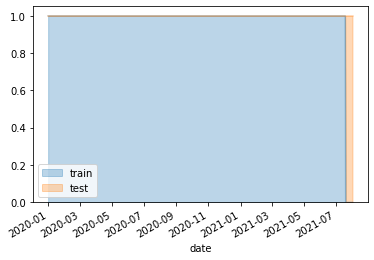

In [9]:
pd.concat([
    pd.DataFrame(index=df_train.date.drop_duplicates(), data={'train':1, 'test':np.nan}),
    pd.DataFrame(index=df_test.date.drop_duplicates(), data={'train':np.nan, 'test':1})
]).plot(kind='area',alpha=0.3)

Маємо дані за 2020-01-01 - 2021-07-19 в тренувальному датасеті, але ... (дивимося нижче)

<AxesSubplot:xlabel='date'>

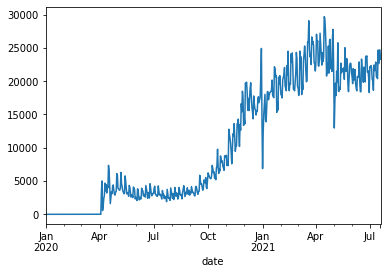

In [21]:
df_train.groupby('date')['sales'].sum().plot()

... насправді маємо значно менше даних. Мабуть, магазини тільки почали відкриватися в 2020 році, або дані по них почали збирати тільки тоді, але стає зрозуміло, що 2020 рік для тренування використовувати не варто. Методом проб і помилок ми дійшли до того, що краще брати дані починаючи з 2020-05-01, що і зробили для нашої моделі.

Подивимося, чи є в тестовому датасеті нові `geoCluster` та `SKU`

In [23]:
for col in ['geoCluster', 'SKU']:
    print(col)
    train_vals = set(df_train[col].unique())
    test_vals = set(df_test[col].unique())

    print('n train values', len(train_vals))
    print('n test values', len(test_vals))
    
    print('train & test n values', len(test_vals & train_vals))
    print('train only values', train_vals - test_vals)
    print('test only values', test_vals - train_vals)
    print() 

geoCluster
n train values 512
n test values 515
train & test n values 512
train only values set()
test only values {2292, 285, 3159}

SKU
n train values 1925
n test values 1961
train & test n values 1925
train only values set()
test only values {848259, 618500, 867715, 830984, 859657, 803605, 441758, 723491, 874109, 803626, 863682, 727362, 868167, 873804, 873805, 725838, 775501, 552921, 725338, 728409, 774878, 763745, 545761, 711138, 785378, 852329, 672233, 759658, 827628, 761066, 859626, 783088, 791922, 570488, 874108, 803581}



Декілька нових артикулів є, але небагато.

Подивимося на ціни декількох випадкових артикулів в обох вибірках.

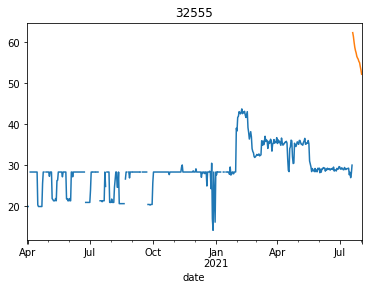

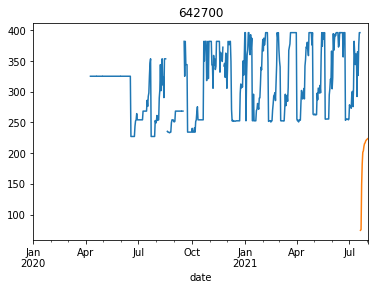

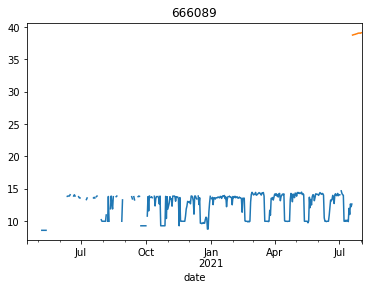

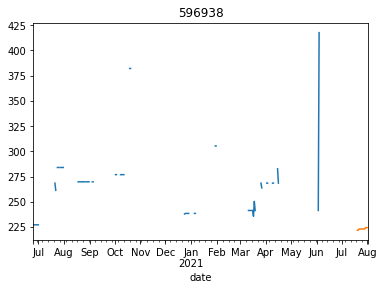

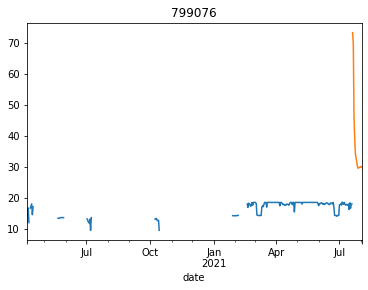

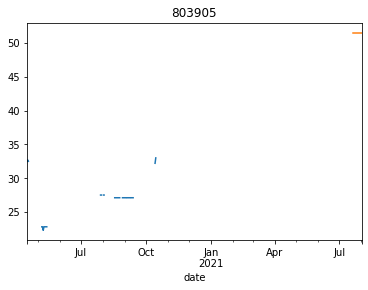

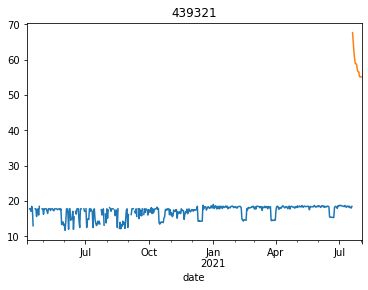

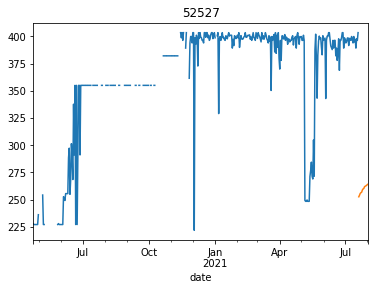

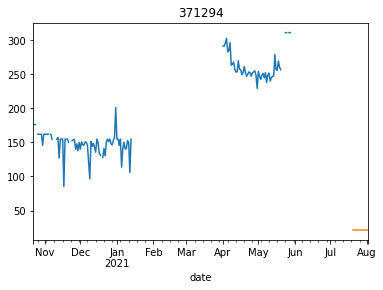

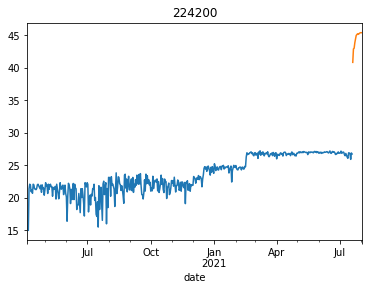

In [27]:
for sku in df_train['SKU'].sample(10).unique():
    df_train[df_train['SKU'] == sku].groupby('date')['price'].mean().plot()
    df_test[df_test['SKU'] == sku].groupby('date')['price'].mean().plot()
    plt.title(sku)
    plt.show()
    plt.close()

Не знаємо, що сталося в ніч між 2021-07-19 та 2021-07-20, але бачимо, що ціни дууууже сильно "стрибають" від трейну до тесту.  Пробували різними способами прибрати викиди з датасету, але це нічим не допомогло. Пробували взагалі прибрати їх з датасетів, але скор став трохи гіршим. Тому залишили як є.

## Розподіли
Поглянемо на розподіли.

In [31]:
df_train['dataset'] = 'train'
df_test['dataset'] = 'test'

df_all = pd.concat([df_train, df_test]).reset_index(drop=True)

Відсіємо дані до 2021-05-01, оскільки самк цей шматок даних ми використовуємо для побудови моделі.

In [43]:
df_all = df_all[df_all['date'] >= '2021-05-01']

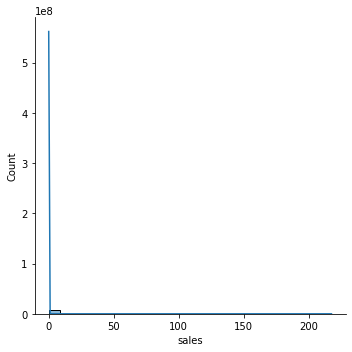

In [44]:
sns.displot(data=df_all[df_all['dataset'] == 'train']['sales'].fillna(0), kde=True)

In [46]:
df_all['price'] = df_all.groupby(['geoCluster', 'SKU'], sort=False)['price'].apply(lambda x: x.ffill().bfill())

/tmp/ipykernel_83825/3795478985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['price'] = df_all.groupby(['geoCluster', 'SKU'], sort=False)['price'].apply(lambda x: x.ffill().bfill())


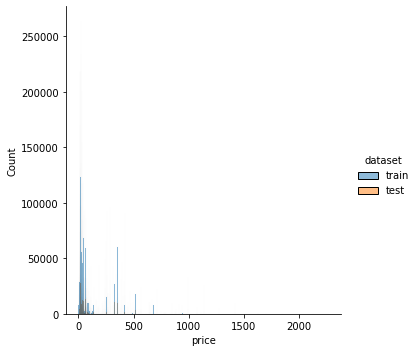

In [47]:
sns.displot(data=df_all, hue='dataset', x='price')

In [54]:
print('Worst geoCluster by sales:', df_all.groupby(['geoCluster'])['sales'].sum().sort_values().head(30))
print('Best geoCluster by sales:', df_all.groupby(['geoCluster'])['sales'].sum().sort_values().tail(30))

Worst geoCluster by sales: geoCluster
285     0.0
2292    0.0
1690    0.0
459     0.0
479     0.0
2668    0.0
1619    0.0
367     0.0
2065    0.0
1747    0.0
3095    0.0
1774    0.0
3159    0.0
2905    0.0
1781    0.0
496     0.0
736     0.0
508     0.0
318     0.2
2953    0.2
260     0.7
434     1.0
445     1.0
682     1.0
440     1.0
1865    1.0
1850    1.0
149     1.0
2368    1.0
744     1.0
Name: sales, dtype: float64
Best geoCluster by sales: geoCluster
2259    14451.800
2045    14452.000
2233    14589.170
2171    14936.562
2041    14952.337
2231    15023.630
2252    15638.200
2908    15882.800
2158    16043.400
2064    16387.350
2042    16721.350
2635    16746.110
2069    17492.350
2262    17545.700
2482    19241.650
3097    19445.611
2077    20871.764
2031    21531.130
2149    21532.365
2735    22932.850
2022    23186.356
2033    23191.600
2049    23420.050
2023    24252.500
2054    24321.250
2056    25358.560
2021    25689.569
2001    29300.050
2043    29641.155
3209    33853.3

In [56]:
print('Worst SKU by sales:', df_all.groupby(['SKU'])['sales'].sum().sort_values().head(30))
print('Best SKU by sales:', df_all.groupby(['SKU'])['sales'].sum().sort_values().tail(30))

Worst SKU by sales: SKU
17        0.0
734569    0.0
728409    0.0
727362    0.0
726767    0.0
726612    0.0
725838    0.0
725338    0.0
724108    0.0
724107    0.0
723491    0.0
722449    0.0
719934    0.0
719932    0.0
718197    0.0
711138    0.0
708035    0.0
703195    0.0
702058    0.0
699411    0.0
699410    0.0
696970    0.0
690798    0.0
689800    0.0
682379    0.0
680212    0.0
679045    0.0
679042    0.0
734570    0.0
679041    0.0
Name: sales, dtype: float64
Best SKU by sales: SKU
32549       9488.026
552812      9813.000
474025     10008.000
567970     10008.000
233272     10320.000
819150     10444.000
838137     10597.000
711838     10776.000
219078     11738.000
437495     11776.000
666058     12012.000
221793     12654.000
67802      12774.000
219149     14043.000
49207      14970.000
787133     15998.000
375210     17987.000
552806     18002.000
819149     18026.000
1008       19154.000
534443     19581.000
20872      20017.000
369071     20777.000
32550      24547.515
3

На цьому огляд даних закінчений, але найбільший інсайт, який дозволить набрати 0.81 на public leaderboard буде нижче.